In [ ]:
# Lesson7：Backtrader来啦：可视化篇（重构）
# link: https://mp.weixin.qq.com/s/WA7Dgr_kcZz-WhriHkf4AQ
# https://cloud.tencent.com/developer/article/1854008

# =============================================================================

In [ ]:
# 第1章 observers 观测器
'''
backtrader.observers.Broker：
    记录了经纪商 broker 中各时间点的可用资金和总资产；可视化时，会同时展示 cash 和 values 曲线；
    如果想各自单独展示 cash 和 values，可以分别调用 backtrader.observers.Cash 和 backtrader.observers.Value；

backtrader.observers.BuySell：
    记录了回测过程中的买入和卖出信号；可视化时，会在价格曲线上标注买卖点；

backtrader.observers.Trades：
    记录了回测过程中每次交易的盈亏（从买入建仓到卖出清仓算一次交易）；可视化时，会绘制盈亏点；

backtrader.observers.TimeReturn：
    记录了回测过程中的收益序列；可视化时，会绘制 TimeReturn 收益曲线；

backtrader.observers.DrawDown：
    记录了回测过程的回撤序列；可视化时，绘制回撤曲线；

backtrader.observers.Benchmark：
    记录了业绩基准的收益序列，业绩基准的数据必须事先通过 adddata、resampledata、replaydata 等数据
    添加函数添加进大脑中 cerebro；可视化时，会同时绘制策略本身的收益序列
    （即：backtrader.observers.TimeReturn 绘制的收益曲线）和业绩基准的收益曲线。

'''

In [ ]:
## 第1.1节 如何添加 observers
'''
addobserver(obscls, *args, **kwargs):
    observers 观测器是通过 addobserver() 添加给大脑 cerebro 的：
    参数 obscls 对应 observers 类下的观测器、*args, **kwargs 对应观测器支持设置的参数

bt.Cerebro(stdstats=False):
    对于 Broker、Trades、BuySell 3个观测器，默认是自动添加给 cerebro 的，
    可以在实例化大脑时，通过 stdstats 来控制：bt.Cerebro(stdstats=False) 表示可视化时，
    不展示 Broker、Trades、BuySell 观测器；反之，自动展示；默认情况下是自动展示。
'''
import backtrader as bt

cerebro = bt.Cerebro(stdstats=False)
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)
# 添加业绩基准时，需要事先将业绩基准的数据添加给 cerebro
banchdata = bt.feeds.PandasData(dataname=data, fromdate=st_date, todate=ed_date)
cerebro.adddata(banchdata, name='xxxx')
cerebro.addobserver(bt.observers.Benchmark, data=banchdata)


In [ ]:
## 第1.2节 如何读取 observers 中的数据
'''
observers 中记录了各种回测数据，可以将其看作是一个支持可视化展示的数据存储器，
所以 observers 属于 lines 对象。如果想在 Strategy 中读取 observers 中的数据，
就会用到 line 的相关操作，observers 的数据通过 self.stats 对象 来连接。

【注意时间】
observers 是在所有指标被计算完之后、在执行 Strategy 的 next 方法之后才运行并统计数据的，
所以读取的最新数据 [0] 相对与 next 的当前时刻是晚一天的。
比如 2019-04-08 的总资产为 99653.196672，2019-04-09 的总资产为 99599.008652，
2019-04-09 这一天的收益为 -0.0005437，如果在 next 通过 self.stats.timereturn.line[0] 提取，
取值为 -0.0005437 时，对应的 next 的当前时间是  2019-04-10
'''


class MyStrategy(bt.Strategy):
    def next(self):
        # 当前时点的前一天的可用现金
        self.stats.broker.cash[0]
        # 当前时点的前一天的总资产
        self.stats.broker.value[0]
        # 获取当前时刻前一天的收益
        self.stats.timereturn.line[0]
        # observers 取得[0]值，对应的 next 中 self.data.datetime[-1] 这一天的值


'''
如果想要将 observers  中的数据保存到本地，可以通过 writer  写入本地文件，如下面的读写到本地 CSV 文件：
'''
import csv


class TestStrategy(bt.Strategy):
    ...

    def start(self):
        self.mystats = csv.writer(open("mystats.csv", "w"))
        self.mystats.writerow(['datetime',
                               'drawdown', 'maxdrawdown',
                               'timereturn',
                               'value', 'cash'])

    def next(self):
        self.mystats.writerow([self.data.datetime.date(-1).strftime('%Y-%m-%d'),
                               '%.4f' % self.stats.drawdown.drawdown[0],
                               '%.4f' % self.stats.drawdown.maxdrawdown[0],
                               '%.4f' % self.stats.timereturn.line[0],
                               '%.4f' % self.stats.broker.value[0],
                               '%.4f' % self.stats.broker.cash[0]])

    def stop(self):
        self.mystats.writerow([self.data.datetime.date(0).strftime('%Y-%m-%d'),
                               '%.4f' % self.stats.drawdown.drawdown[0],
                               '%.4f' % self.stats.drawdown.maxdrawdown[0],
                               '%.4f' % self.stats.broker.value[0],
                               '%.4f' % self.stats.broker.cash[0]])

    # 当运行到最后一根 bar 后， next 中记录的是上一根 bar 的收益
    # stop 是在 next 运行完后才运行的，此时 observers 已经计算完 最后一根 bar 的收益了
    # 所以可以在 stop 中获取最后一根 bar 的收益


In [ ]:
## 第1.3节 自定义 observers
'''
和之前各种自定义一致，自定义 observers 同样是在继承父类  bt.observer.Observer 的基础上，自定义新的的observers。
下面是 Backtrader 官网提供的例子，用于统计已成功创建的订单的价格和到期订单的价格。
'''


class OrderObserver(bt.observer.Observer):
    lines = ('created', 'expired',)

    plotinfo = dict(
        plot=True, subplot=True, plotlinelabels=True
    )

    plotlines = dict(
        created=dict(marker='*', markersize=8.0, color='lime', fillstyle='full'),
        expired=dict(marker='s', markersize=8.0, color='red', fillstyle='full')
    )

    def next(self):
        for order in self._owner._orderspending:
            if order.data is not self.data:
                continue

            if not order.isbuy():
                continue

            # Only interested in "buy" orders, because the sell orders
            # in the strategy are Market orders and will be immediately
            # executed

            if order.status in [bt.Order.Accepted, bt.Order.Submitted]:
                self.lines.created[0] = order.created.price

            elif order.status in [bt.Order.Expired]:
                self.lines.expired[0] = order.created.price


'''
observers 本身是 Lines 对象，所以构建逻辑与自定义 Indicator 类似，
将要统计的数据指定为相应的 line，然后随着回测的进行依次存入数据；

作为 Lines 对象的 Observers 和 Indicator ，类内部都有
plotinfo = dict(...)、plotlines = dict(...) 属性，
用于回测结束后通过 cerebro.plot() 方法进行可视化展示；

有时候如果想修改 Backtrader 已有观测器的相关属性，可以直接继承该观测器，然后设置属性取值进行修改。
如下面在原始 bt.observers.BuySell 的基础上，修改买卖点的样式。
'''


class my_BuySell(bt.observers.BuySell):
    params = (('barplot', True), ('bardist', 0.02),)
    # 将 三角形改为箭头
    plotlines = dict(
        buy=dict(marker=r'$\Uparrow$', markersize=10.0, color='#d62728'),
        sell=dict(marker=r'$\Downarrow$', markersize=10.0, color='#2ca02c')
    )

# =============================================================================

In [ ]:
# 第2章 plot() 图形绘制

'''
cerebro.plot() 支持回测如下 3 大内容：

    Data Feeds：即在回测开始前，通过 adddata、replaydata、resampledata 等方法导入大脑的原始数据；
    Indicators ：即回测时构建的各类指标，比如在 strategy 中构建的指标、通过 addindicator 添加的；
    Observers ：即上文介绍的观测器对象；

在绘制图形时，默认是将 Data Feeds 绘制在主图上；
Indicators 有的与 Data Feeds 一起绘制在主图上，比如均线，
有的以子图形式绘制；Observers 通常绘制在子图上。
'''

## 第2.1节 plot() 中的参数
plot(plotter=None,  # 包含各种绘图属性的对象或类，如果为None，默认取 PlotScheme 类，如下所示
     numfigs=1,  # 是否将图形拆分成多幅图展示，如果时间区间比较长，建议分多幅展示
     iplot=True,  # 在 Jupyter Notebook 上绘图时是否自动 plot inline
     **kwargs)  # 对应 PlotScheme 中的各个参数


# PlotScheme 中的参数如下所示
class PlotScheme(object):
    def __init__(self):
        # X轴、Y轴同时使用紧密排列视图
        self.ytight = False

        # 副图Y轴距离顶和底的边距，不会覆盖plotinfo.plotymargin的设置
        self.yadjust = 0.0
        # 每条新的线都叠加到上一根线下面，如果为False则覆盖到上一根线上面
        self.zdown = True
        # X轴日期的旋转角度
        self.tickrotation = 15

        # 主图中（数据）被分割的数量，与子图的数量成正比
        self.rowsmajor = 5

        # 副图中（指标、观察器）被分割的数量，与子图的数量成正比
        # 与rowsmajor共同决定了主图和副图之间的比例
        self.rowsminor = 1

        # 子图间距
        self.plotdist = 0.0

        # 所有图表添加网格线
        self.grid = True

        # 默认的股价线绘图方式：line（收盘价线），可以另选：'bar'、'candle'
        self.style = 'line'

        # line（收盘价线）颜色
        self.loc = 'black'
        # bar/candle上涨线的颜色（灰度：0.75）
        self.barup = '0.75'
        # bar/candle下跌线的颜色（红色）
        self.bardown = 'red'
        # bar/candle的透明度（1表示完全不透明）
        self.bartrans = 1.0

        # 上涨/下跌线：True=填充，False：透明
        self.barupfill = True
        self.bardownfill = True
        # 填充颜色的透明度
        self.fillalpha = 0.20

        # 是否画出成交量，如果输入数据没有成交量，即使设置为True也不会画出
        self.volume = True

        # 是否直接在股价图上画成交量(True)，还是在副图中画成交量(False)
        self.voloverlay = True
        # 如果voloverlay = True，设置成交量绘图的大小
        self.volscaling = 0.33
        # 如果voloverlay = True，一旦成交量图覆盖股价线太多的话，
        # 设置volpushup移动股价以便让人看清全图
        self.volpushup = 0.00

        # 上涨时成交量柱的颜色
        self.volup = '#aaaaaa'
        # 下跌时成交量柱的颜色
        self.voldown = '#cc6073'
        # 设置当成交量图覆盖住股价线时的透明度
        self.voltrans = 0.50

        # 文字标签的透明度（当前未使用）
        self.subtxttrans = 0.66
        # 标签的文字大小
        self.subtxtsize = 9

        # 图例的透明度（当前未使用）
        self.legendtrans = 0.25
        # 设置指标的图例显示
        self.legendind = True
        # 设置指标的图例位置
        self.legendindloc = 'upper left'

        # 是否显示股价线、指标线的最后一个数据值
        self.linevalues = True

        # 是否在股价线、指标线的最后一个数据打标签
        self.valuetags = True

        # 水平线的默认颜色（0.66灰色） (参考plotinfo.plothlines)
        self.hlinescolor = '0.66'  # shade of gray
        # 水平线的默认样式
        self.hlinesstyle = '--'
        # 水平线的默认宽度
        self.hlineswidth = 1.0

        # 颜色主题：Tableau 10【如果想修改主题色，需要重新定义 tableau10 变量】
        self.lcolors = tableau10

        # X轴显示tick时间的strftime字符串格式
        self.fmt_x_ticks = None

        # X轴显示数据值的strftime字符串格式
        self.fmt_x_data = None


'''
如果想要系统性修改图形样式，可以重新定义 PlotScheme 类，然后修改里面用到的参数；
也可以直接在plot() 中修改。
'''

# 通过参数形式来设置
cerebro.plot(iplot=False,
             style='candel',  # 设置主图行情数据的样式为蜡烛图
             lcolors=colors,  # 重新设置主题颜色
             plotdist=0.1,  # 设置图形之间的间距
             barup='#ff9896', bardown='#98df8a',  # 设置蜡烛图上涨和下跌的颜色
             volup='#ff9896', voldown='#98df8a',  # 设置成交量在行情上涨和下跌情况下的颜色
             )

'''
关于主题颜色，Backtrader 提供了Tableau 10 、Tableau 10 Light、Tableau 20 3种主题色，默认是以 Tableau 10 为主题色。
但是看源代码，不知道如何修改 lcolors，源码 scheme.py 文件中的 tableau10 只一个变量，直接赋值给 self.lcolors = tableau10，
如果在我们在自己的的 notebook上运行 lcolors=tableau10 会报错，提示 tableau10 变量不存在。
所以，如果想修改主题色，需要重新定义 tableau10 变量。

从源码中复制的主题色，后面都注释了索引号，而 Backtrader 在绘制图形时，选择颜色的顺序依次是这样的：
tab10_index = [3, 0, 2, 1, 2, 4, 5, 6, 7, 8, 9]；
tab10_index 中的序号对应的是 主题色 的索引号；

每一幅图，依次取 tab10_index 中的序号对应的颜色来绘制，
比如 MACD 有 3 条 line：
line0 的颜色为 tab10_index[0] = 3，也就是 lcolors=tableau10 中的索引号为 3 对应的颜色 'crimson'；
line1 的颜色为 tab10_index[1] = 0，也就是 lcolors=tableau10 中的索引号为 0 对应的颜色 'blue'；
'''
# 定义主题色变量：直接从源码 scheme.py 中复制的
tableau20 = [
    'steelblue',  # 0
    'lightsteelblue',  # 1
    'darkorange',  # 2
    'peachpuff',  # 3
    'green',  # 4
    'lightgreen',  # 5
    'crimson',  # 6
    'lightcoral',  # 7
    'mediumpurple',  # 8
    'thistle',  # 9
    'saddlebrown',  # 10
    'rosybrown',  # 11
    'orchid',  # 12
    'lightpink',  # 13
    'gray',  # 14
    'lightgray',  # 15
    'olive',  # 16
    'palegoldenrod',  # 17
    'mediumturquoise',  # 18
    'paleturquoise',  # 19
]

tableau10 = [
    'blue',  # 'steelblue', # 0
    'darkorange',  # 1
    'green',  # 2
    'crimson',  # 3
    'mediumpurple',  # 4
    'saddlebrown',  # 5
    'orchid',  # 6
    'gray',  # 7
    'olive',  # 8
    'mediumturquoise',  # 9
]

tableau10_light = [
    'lightsteelblue',  # 0
    'peachpuff',  # 1
    'lightgreen',  # 2
    'lightcoral',  # 3
    'thistle',  # 4
    'rosybrown',  # 5
    'lightpink',  # 6
    'lightgray',  # 7
    'palegoldenrod',  # 8
    'paleturquoise',  # 9
]

# 选一个主题色做修改
cerebro.plot(lcolors=tableau10)

# 当然也可以选自己喜欢的主题色
mycolors = ['#729ece', '#ff9e4a', '#67bf5c',
            '#ed665d', '#ad8bc9', '#a8786e',
            '#ed97ca', '#a2a2a2', '#cdcc5d', '#6dccda']

cerebro.plot(lcolors=mycolors)


In [ ]:
## 第2.2节 局部绘图参数设置
'''
对于 Indicators  和 Observers 的可视化设置，通过类内部的 plotinfo = dict(...)、plotlines = dict(...) 属性来控制，
其中 plotinfo 主要对图形整体布局进行设置，plotlines 主要对具体 line 的样式进行设置。
'''
plotinfo = dict(plot=True,  # 是否绘制
                subplot=True,  # 是否绘制成子图
                plotname='',  # 图形名称
                plotabove=False,  # 子图是否绘制在主图的上方
                plotlinelabels=False,  # 主图上曲线的名称
                plotlinevalues=True,  # 是否展示曲线最后一个时间点上的取值
                plotvaluetags=True,  # 是否以卡片的形式在曲线末尾展示最后一个时间点上的取值
                plotymargin=0.0,  # 用于设置子图 y 轴的边界
                plothlines=[a, b, ...],  # 用于绘制取值为 a,b,... 的水平线
                plotyticks=[],  # 用于绘制取值为 a,b,... y轴刻度
                plotyhlines=[a, b, ...],  # 优先级高于plothlines、plotyticks，是这两者的结合
                plotforce=False,  # 是否强制绘图
                plotmaster=None,  # 用于指定主图绘制的主数据
                plotylimited=True,
                # 用于设置主图的 y 轴边界，
                # 如果True，边界只由主数据 data feeds决定，无法完整显示超出界限的辅助指标；
                # 如果False, 边界由主数据 data feeds和指标共同决定，能确保所有数据都能完整展示
                )


# 修改交易观测器的样式
class my_Trades(bt.observers.Trades):
    plotlines = dict(
        pnlplus=dict(_name='Positive',
                     marker='^', color='#ed665d',
                     markersize=8.0, fillstyle='full'),

        pnlminus=dict(_name='Negative',
                      marker='v', color='#729ece',
                      markersize=8.0, fillstyle='full')
    )


# 修改买卖点样式
class my_BuySell(bt.observers.BuySell):
    params = (('barplot', True), ('bardist', 0.02))  # bardist 控制买卖点与行情线之间的距离
    plotlines = dict(
        buy=dict(marker=r'$\Uparrow$', markersize=10.0, color='#d62728'),
        sell=dict(marker=r'$\Downarrow$', markersize=10.0, color='#2ca02c')
    )

In [ ]:
## 第2.3节 部分修改效果
'''
一般主图的样式通过 plot() 中的参数来设置；
Indicators  和 Observers 的样式通过继承原始类，然后通过修改plotinfo 和 plotlines 属性来设置；
'''

'【蜡烛图样式】'
import matplotlib.pyplot as plt

plt.style.use('seaborn')  # 使用 seaborn 主题
plt.rcParams['figure.figsize'] = 20, 10  # 全局修改图大小


# 修改 Trades 观测器的样式
class my_Trades(bt.observers.Trades):
    plotlines = dict(
        pnlplus=dict(_name='Positive',
                     marker='^', color='#ed665d',
                     markersize=8.0, fillstyle='full'),

        pnlminus=dict(_name='Negative',
                      marker='v', color='#729ece',
                      markersize=8.0, fillstyle='full')
    )


# 修改 BuySell 的样式
class my_BuySell(bt.observers.BuySell):
    params = (('barplot', True), ('bardist', 0.02))
    plotlines = dict(
        buy=dict(marker=r'$\Uparrow$', markersize=10.0, color='#d62728'),
        sell=dict(marker=r'$\Downarrow$', markersize=10.0, color='#2ca02c')
    )


# 简单均线策略
class TestStrategy(bt.Strategy):
    ......


# 绘制图形
cerebro1 = bt.Cerebro(stdstats=False)
# ......
# 添加观测器
cerebro1.addobserver(bt.observers.DrawDown)
cerebro1.addobserver(bt.observers.Benchmark, data=datafeed1)
cerebro1.addobserver(bt.observers.Broker)
cerebro1.addobserver(my_Trades)
cerebro1.addobserver(my_BuySell)
#先运行策略
rasult = cerebro1.run()
#策略运行完后，绘制图形
colors = ['#729ece', '#ff9e4a', '#67bf5c', '#ed665d', '#ad8bc9', '#a8786e', '#ed97ca', '#a2a2a2', '#cdcc5d', '#6dccda']
tab10_index = [3, 0, 2, 1, 2, 4, 5, 6, 7, 8, 9]
cerebro1.plot(iplot=False,
              style='line',  # 绘制线型价格走势，可改为 'candel' 样式
              lcolors=colors,
              plotdist=0.1,
              bartrans=0.2,
              volup='#ff9896',
              voldown='#98df8a',
              loc='#5f5a41',
              # 蜡烛之间会比较拥挤，可以通过设置 numfigs=2，分 2 部分绘制
              # numfigs=2,
              grid=False)  # 删除水平网格

# =============================================================================

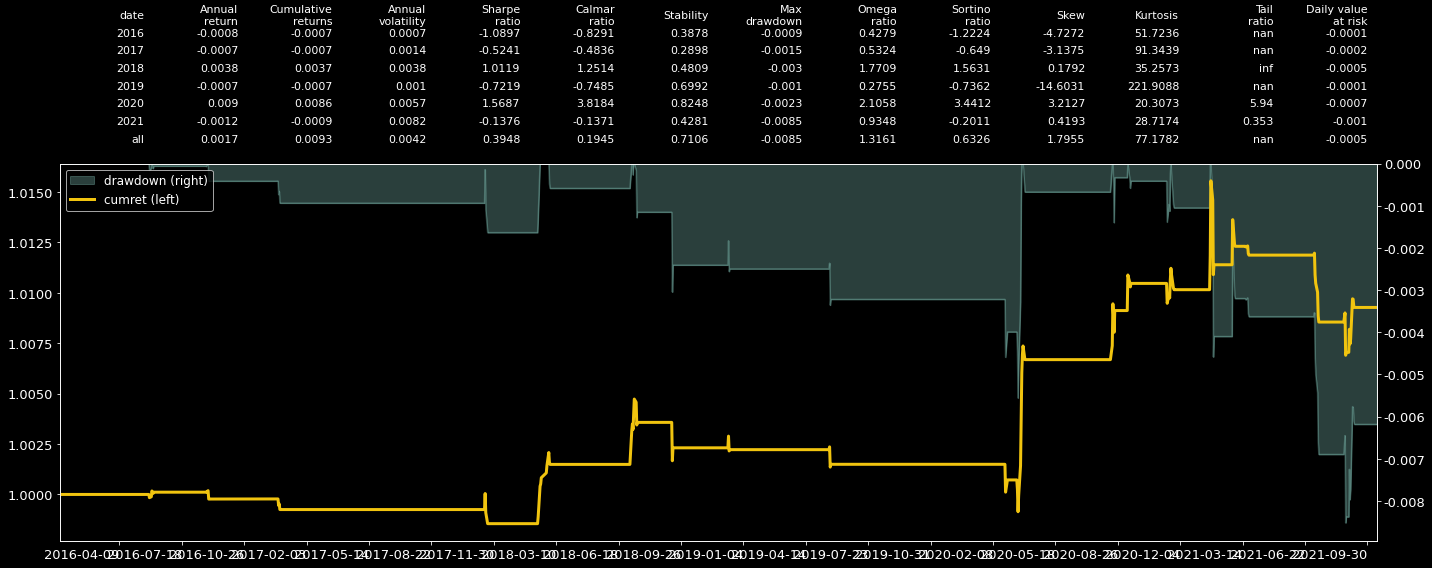

In [2]:
# 第3章 基于收益序列进行可视化
'''
Backtrader 自带的绘图工具方便好用，不过平时在汇报策略回测结果时，可能更关注的是策略的累计收益曲线和业绩评价指标等结果，
而这些回测统计信息只需基于回测返回的 TimeReturn 收益序列做简单计算即可得到。
下面是基于 Backtrader 回测返回的分析器 TimeReturn、pyfolio、matplotlib 得到的可视化图形。
'''
import numpy as np
import pandas as pd
import backtrader as bt
import warnings

warnings.filterwarnings('ignore')

import tushare as ts
import json

with open(r'Data/tushare_token.json', 'r') as load_json:
    token_json = json.load(load_json)
token = token_json['token']
ts.set_token(token)
pro = ts.pro_api(token)

# 使用Tushare获取数据，要严格保持OHLC的格式
df = ts.pro_bar(ts_code='600276.SH', adj='qfq', start_date='20160101', end_date='20211015')
df = df[['trade_date', 'open', 'high', 'low', 'close', 'vol']]
df.columns = ['trade_date', 'open', 'high', 'low', 'close', 'volume']
df.trade_date = pd.to_datetime(df.trade_date)
# 索引必须是日期
df.index = df.trade_date
# 日期必须要升序
df.sort_index(inplace=True)


# Create a Stratey
class TestStrategy(bt.Strategy):
    # 设定参数，便于修改
    params = (
        ('maperiod', 60),
    )

    def log(self, txt, dt=None):
        '''
        日志函数：打印结果
        datas[0]：传入的数据，包含日期、OHLC等数据
        datas[0].datetime.date(0)：调用传入数据中的日期列
        '''
        dt = dt or self.datas[0].datetime.date(0)
        # print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # dataclose变量：跟踪当前收盘价
        self.dataclose = self.datas[0].close

        # order变量：跟踪订单状态
        self.order = None
        # buyprice变量：买入价格
        self.buyprice = None
        # buycomm变量：买入时佣金费用
        self.buycomm = None

        # 指标：简单移动平均 MovingAverageSimple【15天】
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)

        # 添加画图专用指标
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)

        self.my_indicator_kdj = bt.indicators.StochasticFull(self.datas[0], period=9)

    def notify_order(self, order):
        '''订单状态通知(order.status)：提示成交状态'''
        if order.status in [order.Submitted, order.Accepted]:
            # 如果订单只是提交状态，那么啥也不提示
            return

        # 检查订单是否执行完毕
        # 注意：如果剩余现金不足，则会被拒绝！
        if order.status in [order.Completed]:
            if order.isbuy():
                # 买入信号记录：买入价、买入费用、买入佣金费用
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                # 卖出信号记录：卖出价、卖出费用、卖出佣金费用
                self.log(
                    'SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

            # 记录订单执行的价格柱的编号（即长度）
            self.bar_executed = len(self)

        # 如果订单被取消/保证金不足/被拒绝
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # 如果没有查询到订单，则订单为None
        self.order = None

    def notify_trade(self, trade):
        '''交易状态通知：查看交易毛/净利润'''
        if not trade.isclosed:
            return
        # 交易毛利润：trade.pnl、交易净利润：trade.pnlcomm（扣除佣金）
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    # 交易策略主函数
    def next(self):
        # 记录收盘价
        self.log('Close, %.2f' % self.dataclose[0])

        # 检查一下是否有订单被挂起，如果有的话就先不下单
        if self.order:
            return

        # 检查一下目前是否持有头寸，如果没有就建仓
        if not self.position:

            # 如果 K角度>0 且 K>D 且  K<50:
            if (self.my_indicator_kdj.percK[0] > self.my_indicator_kdj.percK[-1]) & (
                    self.my_indicator_kdj.percK[0] > self.my_indicator_kdj.percD[0]) & (
                    self.my_indicator_kdj.percK[0] < 20):
                # 买买买！先记录一下买入价格（收盘价）
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                # 更新订单状态：buy()：开仓买入，买入价是下一个数据，即【开盘价】
                self.order = self.buy()
        else:
            # 如果已经建仓，并持有头寸，则执行卖出指令
            # 如果 K角度<0 且 K<D 且 K>70:
            if (self.my_indicator_kdj.percK[0] < self.my_indicator_kdj.percK[-1]) & (
                    self.my_indicator_kdj.percK[0] < self.my_indicator_kdj.percD[0]):
                # 卖!卖!卖!
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                # 更新订单状态：sell()：平仓卖出，卖出价是下一个数据，即【开盘价】
                self.order = self.sell()


# 创建实例
cerebro = bt.Cerebro()
# 添加策略
cerebro.addstrategy(TestStrategy)
# 添加数据源
data = bt.feeds.PandasData(dataname=df)
# 输入数据源
cerebro.adddata(data)
# 设置初始现金：10万
cerebro.broker.setcash(1000000.0)
# 设定每次买入的股票数量：10股
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
# 设置佣金费率：双边0.1%
cerebro.broker.setcommission(commission=0.001)

# 回测时需要添加 TimeReturn 分析器
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
result = cerebro.run()

# 提取收益序列
pnl = pd.Series(result[0].analyzers._TimeReturn.get_analysis())
# 计算累计收益
cumulative = (pnl + 1).cumprod()
# 计算回撤序列
max_return = cumulative.cummax()
drawdown = (cumulative - max_return) / max_return

# 计算收益评价指标
import pyfolio as pf

# 按年统计收益指标
perf_stats_year = (pnl).groupby(pnl.index.to_period('y')).apply(lambda data: pf.timeseries.perf_stats(data)).unstack()
# 统计所有时间段的收益指标
perf_stats_all = pf.timeseries.perf_stats((pnl)).to_frame(name='all')
perf_stats = pd.concat([perf_stats_year, perf_stats_all.T], axis=0)
perf_stats_ = round(perf_stats, 4).reset_index()

# 绘制图形
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import matplotlib.ticker as ticker  # 导入设置坐标轴的模块

# plt.style.use('seaborn')
plt.style.use('dark_background')

fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1.5, 4]}, figsize=(20, 8))
cols_names = ['date', 'Annual\nreturn', 'Cumulative\nreturns', 'Annual\nvolatility',
              'Sharpe\nratio', 'Calmar\nratio', 'Stability', 'Max\ndrawdown',
              'Omega\nratio', 'Sortino\nratio', 'Skew', 'Kurtosis', 'Tail\nratio',
              'Daily value\nat risk']

# 绘制表格
ax0.set_axis_off()  # 除去坐标轴
table = ax0.table(cellText=perf_stats_.values,
                  bbox=(0, 0, 1, 1),  # 设置表格位置， (x0, y0, width, height)
                  rowLoc='right',  # 行标题居中
                  cellLoc='right',
                  colLabels=cols_names,  # 设置列标题
                  colLoc='right',  # 列标题居中
                  edges='open'  # 不显示表格边框
                  )
table.set_fontsize(13)

# 绘制累计收益曲线
ax2 = ax1.twinx()
ax1.yaxis.set_ticks_position('right')  # 将回撤曲线的 y 轴移至右侧
ax2.yaxis.set_ticks_position('left')  # 将累计收益曲线的 y 轴移至左侧
# 绘制回撤曲线
drawdown.plot.area(ax=ax1, label='drawdown (right)', rot=0, alpha=0.3, fontsize=13, grid=False)
# 绘制累计收益曲线
(cumulative).plot(ax=ax2, color='#F1C40F', lw=3.0, label='cumret (left)', rot=0, fontsize=13, grid=False)
# 不然 x 轴留有空白
ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
# 主轴定位器：每 5 个月显示一个日期：根据具体天数来做排版
ax2.xaxis.set_major_locator(ticker.MultipleLocator(100))
# 同时绘制双轴的图例
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, fontsize=12, loc='upper left', ncol=1)

fig.tight_layout()  # 规整排版
plt.show()